## Penguin Out of Distribution

Let's play some simple outlier detection games on a well known penguins dataset in order to gain some intuitions on these algorithms.  If one wanted to play more detailed games with outlier detection then we would recommend that they explore the [PyOD package](https://pyod.readthedocs.io/).

In [1]:
import thisnotthat as tnt
import panel as pn

2023-03-24 15:33:28.035170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


To make Panel based objects interactive within a notebook we need to load the panel `extension`.

In [2]:
pn.extension()

In [3]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import DecisionBoundaryDisplay
import umap
#Outlier detectors
import hdbscan
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
penguins = sns.load_dataset("penguins").dropna(how="any", axis=0)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Next we build a pipeline scale and embed the numberic columns of the penguin data into a two dimensional euclidean space, or data map.

In [5]:
pipe = Pipeline([('scaler', RobustScaler()), ('umap', umap.UMAP(random_state=37))])
penguin_datamap = pipe.fit_transform(penguins.select_dtypes(include="number"))

Now we will select a subset of points and build outlier detection models (out of distribution detection) for this selection.  We will then evaluate the outlier detection model across a grid space of our two dimensional data maps.

In [6]:
#selected = penguins.species=='Chinstrap'
#selected = penguins.species=='Gentoo'
#selected = penguins.species=='Adelie'
selected = (penguins.species=='Chinstrap') | (penguins.species=='Gentoo')

feature_1, feature_2 = np.meshgrid(
    np.linspace(penguin_datamap[:, 0].min(), penguin_datamap[:, 0].max()), 
    np.linspace(penguin_datamap[:, 1].min(), penguin_datamap[:, 1].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

#hdbscan 
hdbscan_ood = hdbscan.HDBSCAN(prediction_data=True).fit(penguin_datamap[selected])
grid_predicted = 1-hdbscan.approximate_predict_scores(hdbscan_ood, grid)
hdbscan_grid_pred = np.reshape(grid_predicted, feature_1.shape)

#lof
lof_ood = LocalOutlierFactor(novelty=True).fit(penguin_datamap[selected])
grid_predicted = lof_ood.score_samples(grid)
lof_grid_pred = np.reshape(grid_predicted, feature_1.shape)

#gaussian mixture model
gmm_ood = GaussianMixture(n_components=10).fit(penguin_datamap[selected])
grid_predicted = gmm_ood.score_samples(grid)
gmm_grid_pred = np.reshape(grid_predicted, feature_1.shape)

#isolation forest
iso_ood = IsolationForest().fit(penguin_datamap[selected])
grid_predicted = iso_ood.score_samples(grid)
iso_grid_pred = np.reshape(grid_predicted, feature_1.shape)

#One class SVM
svm_ood = OneClassSVM().fit(penguin_datamap[selected])
grid_predicted = svm_ood.score_samples(grid)
svm_grid_pred = np.reshape(grid_predicted, feature_1.shape)

# use grid search cross-validation to optimize the bandwidth of a kde
params = {"bandwidth": np.logspace(-1, 1, 40)}
kde_ood_grid = GridSearchCV(KernelDensity(), params)
kde_ood_grid.fit(penguin_datamap[selected])
kde_ood = kde_ood_grid.best_estimator_
grid_predicted = kde_ood.score_samples(grid)
kde_grid_pred = np.reshape(grid_predicted, feature_1.shape)

#collect the results
outlier_grid = [hdbscan_grid_pred, iso_grid_pred, svm_grid_pred,  lof_grid_pred, gmm_grid_pred, kde_grid_pred]
titles = ['hdbscan outlier scores', 'isolation forest scores', 'one class svm scores',  'lof outlier scores', 'gmm outlier scores', f'kde scores (bw={kde_ood.bandwidth:0.3})']
sample_evaluation = pd.DataFrame([1-hdbscan.approximate_predict_scores(hdbscan_ood, penguin_datamap), iso_ood.score_samples(penguin_datamap), svm_ood.score_samples(penguin_datamap), lof_ood.score_samples(penguin_datamap), gmm_ood.score_samples(penguin_datamap), kde_ood.score_samples(penguin_datamap)]).T
sample_evaluation.columns = titles

Now let's plot the results of the grid space evaluation.

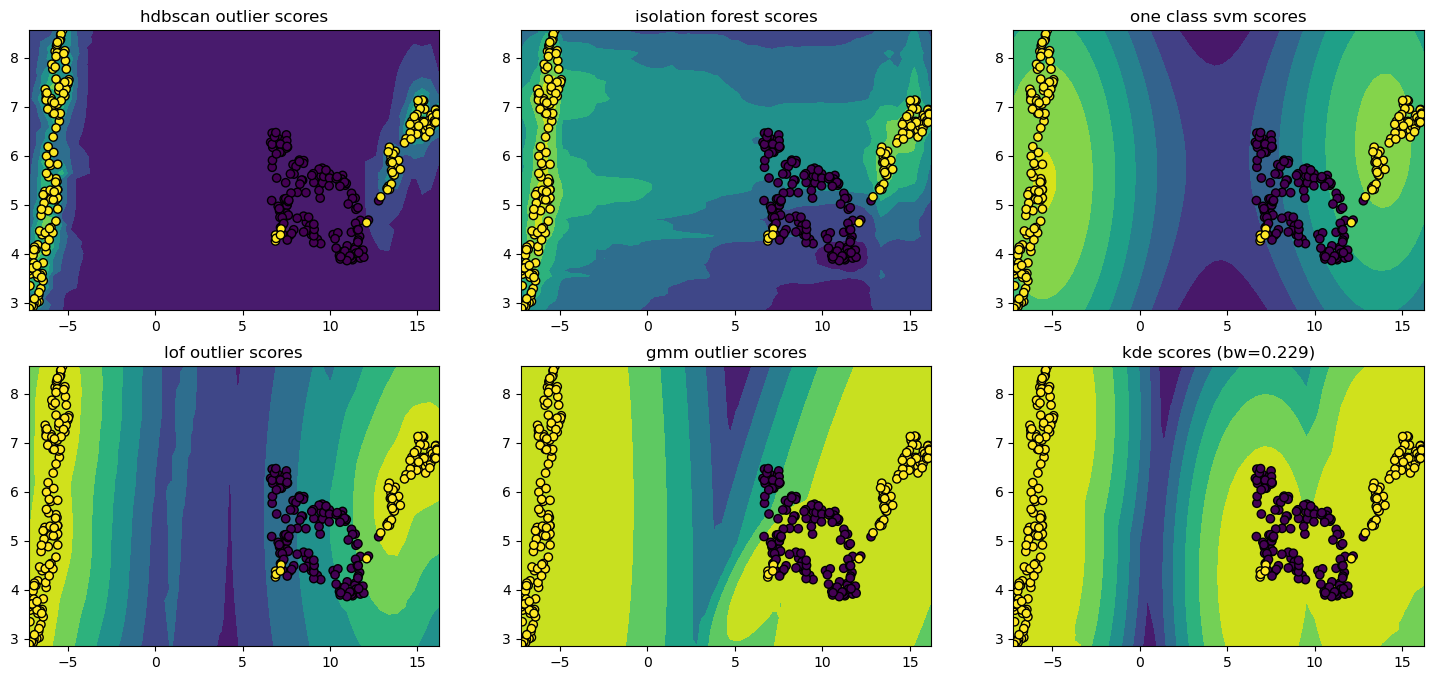

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
ax = ax.T.flatten('F')
i = 0

for i in range(len(outlier_grid)):
    disp = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=outlier_grid[i])
    disp.plot(ax=ax[i])
    ax[i].scatter(penguin_datamap[:, 0], penguin_datamap[:, 1], c=selected, edgecolor="k")
    ax[i].title.set_text(titles[i])

We see that:
1) HDBSCAN: Fit very tight decision boundaries around our data and ignored the cluster that was below minimum cluster size.  The sharply dropping off decision boundary might be advantageous for cases were we have little trust in what distance means in the empty regions of our embedding.
2) Isolation Forest: Fit the dense regions of our space well but have some lensing effects which might not be desirable depending on your use case.
3) One Class SVM: Fit's a single decision regions with a simple gradient boundary.  This might not be ideal for multimodal or strangely shaped decision regions.  
4) LOF: Is algorithmically quite similar to HDBSCAN.  It fits much looser decision boundareies around our data while ignoring the cluster that was below minimum cluster size.  It should be noted that the has a much smoother gradient to the decision function which could be advantageous in some cases.
5) Gaussian Mixture Model: This was a 10 component mixture model with the full covarance being fit.  Notice the very wide regions of high likelihood.  This is caused by the objective function trying to maximize the likelihood of the data while have no penalty to contrain the expansions of it's kernels.
6) Kernel Density Estimator: This provides very similar results to the GMM for exactly the same reasons.  The advantage here is that we don't need to select a number of mixture components.  That allows us to be more flexible in the number of clumps of data being fit.  The disadvantage is that we aren't fitting the full covarance matrix to our data.  That can cause serious difficulties in variable density regions of our space where a single bandwidth kernel is being placed over every point.

Below we see the pairs plots of these outlier scores evaluated over all the data.  That allows us to see how they are distributed as well as how they relate to each other.

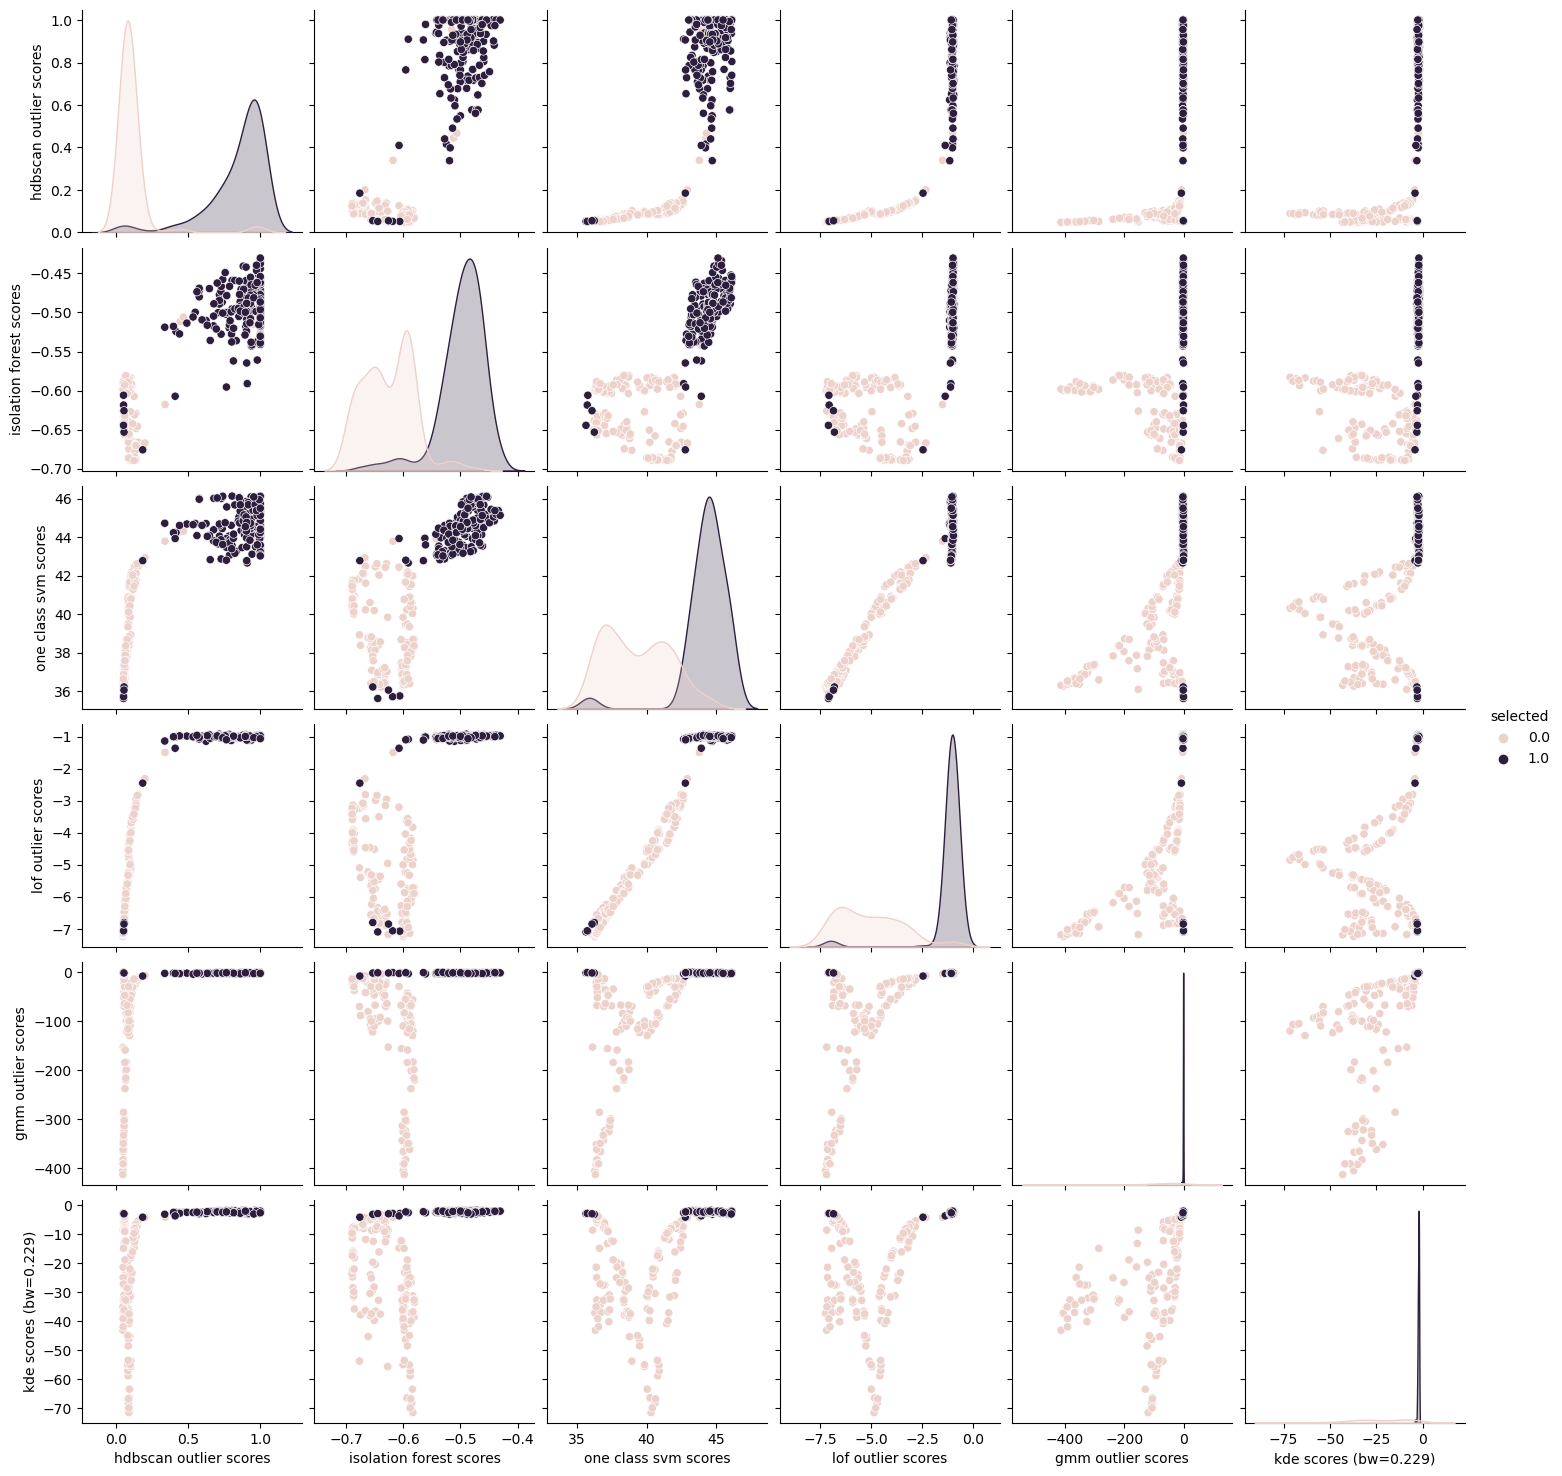

In [8]:
sample_evaluation['selected'] = selected
sns.pairplot(sample_evaluation, hue='selected');